# FinCompress — Complete Pipeline Notebook
**Run on: Google Colab with T4 GPU**

This single notebook runs the **entire FinCompress pipeline** from start to finish, in one session.

| Section | What it does | Est. Time on T4 |
|---------|-------------|-----------------|
| 0. Setup | Mount Drive, install deps | ~5 min |
| 1. Dataset | Download + split data | ~2 min |
| 2. Teacher | Fine-tune FinBERT | ~45–60 min |
| 3a. Vanilla KD | Soft-label knowledge distillation | ~30–45 min |
| 3b. Intermediate KD | Hidden-state + attention supervision | ~30–45 min |
| 4a. PTQ | Post-training INT8 quantization | ~5 min |
| 4b. QAT | Quantization-aware training | ~20–30 min |
| 5. Pruning | Structured prune + recovery | ~60–90 min |
| 6. Benchmark | Evaluate all 7 variants | ~10–15 min |
| 7. Plots | 6 publication-quality figures | ~2 min |
| 8. Export | ZIP checkpoints for local use | ~2 min |

**Total: ~3–5 hours.** Use Runtime → Run all, then walk away.

> ⚠️ Before starting: **Runtime → Change runtime type → T4 GPU**

---
## Section 0 — Setup

This cell does everything needed to start: mounts Google Drive, clones (or updates) the repo, installs all Python dependencies, and verifies GPU access.

**Run this cell once.** Every subsequent cell assumes it has completed successfully. If your session disconnects and restarts, just re-run this cell before continuing.

In [9]:
# ── Section 0: Setup ─────────────────────────────────────────────────────────
# Mounts Drive, clones repo (first run only), installs deps, checks GPU.
# Run ONCE per session — every other cell depends on this.
#
# ⚠️  We intentionally skip `git pull` because git uses mmap() for pack-file
#     operations, which causes SIGBUS (signal 7) on Google Drive's FUSE mount.
#     To manually pull latest code: open a new cell and run:
#       !git -C "/content/drive/MyDrive/fincompress" fetch --depth 1 && git reset --hard origin/main

from google.colab import drive
import os, sys, shutil, torch

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define project root — ALL subsequent cells use this variable
PROJECT_PATH = '/content/drive/MyDrive/fincompress'

# Step 3: Clone repo if not fully present; skip all git ops if already there
# We check for requirements_colab.txt (only exists after a successful clone)
# rather than .git/ (which is created at the START of a clone, even if interrupted).
SENTINEL = os.path.join(PROJECT_PATH, 'requirements_colab.txt')

if os.path.exists(SENTINEL):
    print("✅ Repo already on Drive — using existing version.")
else:
    if os.path.exists(PROJECT_PATH):
        print("⚠️  Incomplete/corrupted clone detected — removing and re-cloning...")
        shutil.rmtree(PROJECT_PATH)
    print("Cloning FinCompress from GitHub (shallow clone, ~1 min)...")
    ret = os.system(f'git clone --depth 1 https://github.com/Rohanjain2312/FinCompress.git "{PROJECT_PATH}"')
    if ret != 0 or not os.path.exists(SENTINEL):
        raise RuntimeError("❌ Clone failed. Check internet connection and retry this cell.")
    print("✅ Clone complete.")

# Step 4: Change into project directory and add to Python path
os.chdir(PROJECT_PATH)
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)
print(f"Working directory: {os.getcwd()}")

# Step 5: Install all dependencies
print("\nInstalling dependencies (3–5 min on first run, fast after that)...")
os.system('pip install -r requirements_colab.txt -q')
print("Dependencies installed ✓")

# Step 6: Verify GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    vram_gb  = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n✅ GPU ready: {gpu_name} ({vram_gb:.1f} GB VRAM)")
else:
    print("\n⚠️  WARNING: No GPU detected.")
    print("   Go to Runtime → Change runtime type → T4 GPU, then re-run this cell.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Repo already on Drive — using existing version.
Working directory: /content/drive/MyDrive/fincompress

Installing dependencies (3–5 min on first run, fast after that)...
Dependencies installed ✓

✅ GPU ready: Tesla T4 (15.6 GB VRAM)


---
## Section 1 — Dataset Preparation

We train and evaluate on a merged dataset combining two complementary financial sentiment sources:

| Dataset | Source | Size | Labels |
|---------|--------|------|--------|
| **FinancialPhraseBank** (allagree) | Expert-annotated financial news sentences | ~2,264 | negative / neutral / positive |
| **FiQA-2018 Sentiment** | Crowdsourced financial Q&A with continuous scores | ~1,174 | Continuous [−1, 1] → thresholded |

**Why Macro F1 (not accuracy)?** Financial news is class-imbalanced (~60% neutral). Accuracy rewards predicting "neutral" always. Macro F1 weights all three classes equally, penalising models that ignore the minority class.

**Splits:** Stratified 70 / 15 / 15 — each split preserves the same class distribution as the full dataset.

> ⏱️ **~2 minutes** on first run (downloads from HuggingFace Hub). If the CSVs already exist on Drive from a previous run, this cell skips the download automatically.

In [10]:
# ── Section 1: Dataset Preparation ──────────────────────────────────────────
# Downloads FinancialPhraseBank + FiQA-2018 from HuggingFace Hub, merges,
# cleans, and splits 70/15/15 (stratified). Saves train/val/test CSVs to
# fincompress/data/. Skips download if CSVs already exist on Drive.

import os, pandas as pd

DATA_DIR  = os.path.join(PROJECT_PATH, 'fincompress', 'data')
train_csv = os.path.join(DATA_DIR, 'train.csv')

if not os.path.exists(train_csv):
    print("Downloading and preparing datasets (2–3 min)...")
    !python -m fincompress.data.prepare_dataset
else:
    print("Dataset CSVs already on Drive — skipping download.\n")

df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_val   = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
df_test  = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
print("Class distribution by split:")
print("-" * 45)
for split_name, df in [('TRAIN', df_train), ('VAL', df_val), ('TEST', df_test)]:
    print(f"\n{split_name} ({len(df)} samples):")
    print(df['label'].map(label_map).value_counts(normalize=True).round(3).to_string())

Dataset CSVs already on Drive — skipping download.

Class distribution by split:
---------------------------------------------

TRAIN (2358 samples):
label
neutral     0.436
positive    0.372
negative    0.193

VAL (506 samples):
label
neutral     0.437
positive    0.372
negative    0.192

TEST (506 samples):
label
neutral     0.437
positive    0.372
negative    0.192


---
## Section 2 — Teacher Training

We fine-tune **ProsusAI/FinBERT** — a BERT-base model further pre-trained on 4.9 billion tokens of financial text (news, earnings call transcripts, analyst reports) — as our teacher model.

**Why FinBERT over vanilla BERT?** Financial text has a very different distribution from Wikipedia/BookCorpus. FinBERT provides:
- Better tokenisation of financial terms ("EPS beat", "EBITDA" appear as single tokens, not broken subwords)
- Contextualized representations that already encode domain-specific sentiment signals
- Higher baseline accuracy on financial NLP *before* any task-specific fine-tuning

**Training strategy:**
- **Optimizer:** AdamW, lr = 2e-5, weight decay = 0.01 (bias and LayerNorm excluded)
- **Schedule:** Linear warmup for 10% of steps, then linear decay — prevents destructive gradient updates early in fine-tuning
- **Early stopping:** Patience = 3 consecutive epochs without val F1 improvement
- **Target:** Val Macro F1 ≥ 0.87 — below this threshold, the teacher's soft labels don't carry enough structure for effective distillation

The best checkpoint (by val Macro F1) is saved automatically to `fincompress/checkpoints/teacher/`.

> ⏱️ **~45–60 minutes on T4 GPU.**

In [11]:
# ── Section 2a: Train Teacher ────────────────────────────────────────────────
# Fine-tunes FinBERT on the merged financial sentiment dataset.
# Logs: fincompress/logs/teacher_training.csv
# Output: fincompress/checkpoints/teacher/  (best by val Macro F1)

!python -m fincompress.teacher.train_teacher

2026-03-01 01:32:51.668240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772328771.724910   15225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772328771.744767   15225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772328771.786098   15225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772328771.786138   15225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772328771.786146   15225 computation_placer.cc:177] computation placer alr

**Reading the plots below:**
- **Left — Loss curves:** Both train and val loss should decrease together. If val loss rises while train loss keeps falling, the model is overfitting (early stopping will catch this).
- **Right — Val Macro F1:** The green line should cross the red dashed target line at F1 = 0.87. If it plateaus below 0.87, the teacher isn't strong enough to be an effective distillation target.

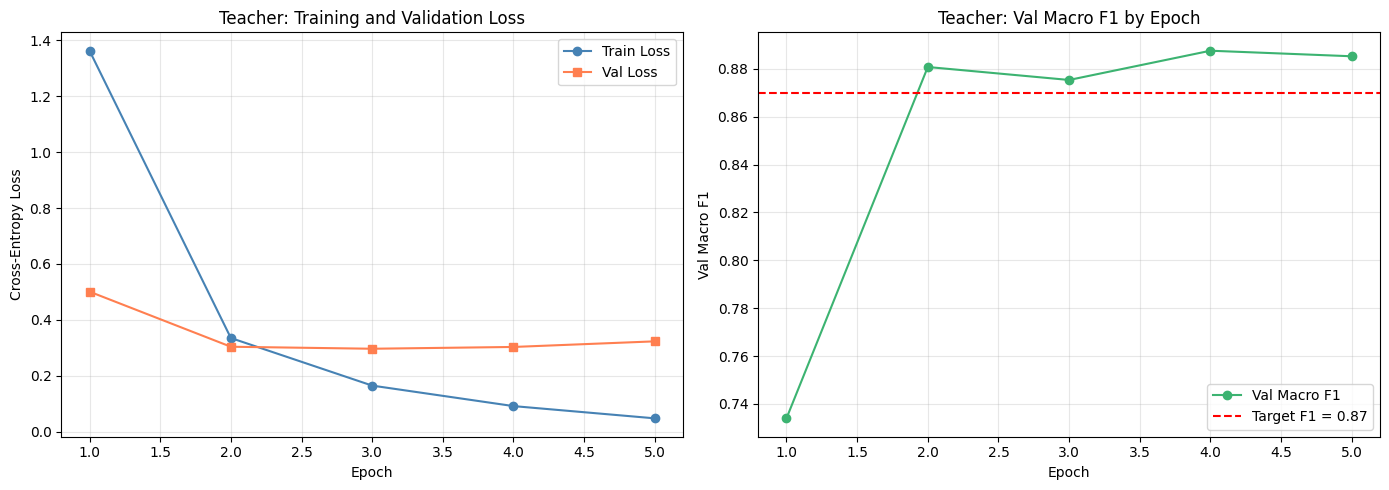

Best val Macro F1: 0.8876


In [12]:
# ── Section 2b: Teacher Loss Curves ─────────────────────────────────────────
# Plots train/val loss and val Macro F1 across epochs.
# Target: val F1 crosses 0.87 (red dashed line).

import pandas as pd, matplotlib.pyplot as plt, os

log_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'logs', 'teacher_training.csv'))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(log_df['epoch'], log_df['train_loss'], 'o-', label='Train Loss', color='steelblue')
axes[0].plot(log_df['epoch'], log_df['val_loss'],   's-', label='Val Loss',   color='coral')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('Teacher: Training and Validation Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(log_df['epoch'], log_df['val_f1'], 'o-', color='mediumseagreen', label='Val Macro F1')
axes[1].axhline(y=0.87, color='red', linestyle='--', label='Target F1 = 0.87')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Val Macro F1')
axes[1].set_title('Teacher: Val Macro F1 by Epoch')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Best val Macro F1: {log_df['val_f1'].max():.4f}")

**Reading the confusion matrix below:**
The matrix shows where the teacher makes mistakes on the validation set. Common patterns in financial sentiment:
- **Negative ↔ Neutral** (most common error): Hedged language like *"results were below expectations"* sits close to the neutral boundary in representation space
- **Positive ↔ Neutral** (less common): Explicit language like *"record revenues"* is usually unambiguous
- **Negative ↔ Positive** (rare): Direct sentiment opposites are linguistically clear

This tells us what to watch for in compressed variants — accuracy degradation typically shows up first as lower negative recall.

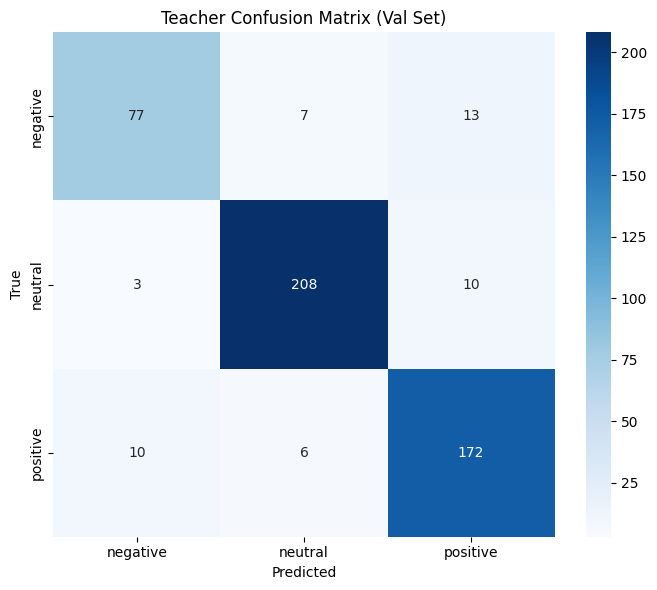

In [13]:
# ── Section 2c: Teacher Confusion Matrix ─────────────────────────────────────
# Runs the saved teacher on the val set and plots a 3×3 confusion matrix.
# Shows which sentiment classes the teacher confuses most.

import torch, os, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset

class FinDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts  = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len,
                       padding='max_length', truncation=True, return_tensors='pt')
        return {'input_ids':      enc['input_ids'].squeeze(0),
                'attention_mask': enc['attention_mask'].squeeze(0),
                'label':          torch.tensor(self.labels[i])}

device    = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_dir  = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', 'teacher')
tokenizer = AutoTokenizer.from_pretrained(os.path.join(ckpt_dir, 'tokenizer'))
teacher   = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).to(device)
teacher.eval()

df_val = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'data', 'val.csv'))
loader = DataLoader(FinDataset(df_val, tokenizer, 128), batch_size=64)

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in loader:
        out = teacher(batch['input_ids'].to(device),
                      attention_mask=batch['attention_mask'].to(device))
        all_preds.extend(out.logits.argmax(dim=-1).cpu().tolist())
        all_labels.extend(batch['label'].tolist())

label_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_title('Teacher Confusion Matrix (Val Set)')
plt.tight_layout(); plt.show()

---
## Section 3 — Knowledge Distillation

Knowledge distillation trains a **smaller student model** to mimic the teacher by learning from the teacher's full output probability distributions — not just hard ground-truth labels.

### 3a — Vanilla KD (Soft-Label Distillation)

**Why soft labels?** When the teacher outputs [0.05, 0.72, 0.23] for a sentence, it's telling the student: *"this is probably neutral, but has some positive signal."* A hard label of "neutral" discards this nuance entirely. The student trained on soft labels learns the teacher's uncertainty structure, not just its final answer.

**Temperature T:** Softens the distribution before computing KL divergence: `p_i = exp(z_i / T) / Σ exp(z_j / T)`. Higher T → softer distribution → more gradient signal about non-dominant classes.

**T² scaling:** Multiplying the KL loss by T² compensates for the reduced gradient magnitude at high temperatures — without this, the CE loss would dominate.

**Alpha (α):** Balances the two loss terms:
```
L = α · T² · KL(student ‖ teacher_soft) + (1 − α) · CE(student, hard_labels)
```

> ⏱️ **~30–45 minutes on T4 GPU.** Student checkpoint saved to `fincompress/checkpoints/student_vanilla_kd/`.

In [14]:
# ── Section 3a-i: Train Vanilla KD Student ───────────────────────────────────
# Trains a 4-layer, 384-hidden, 6-head student using soft-label KL divergence.
# Logs: fincompress/logs/vanilla_kd_training.csv
# Output: fincompress/checkpoints/student_vanilla_kd/

!python -m fincompress.distillation.soft_label_distillation

2026-03-01 01:38:04.598379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772329084.632780   16796 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772329084.643143   16796 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772329084.668441   16796 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772329084.668486   16796 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772329084.668495   16796 computation_placer.cc:177] computation placer alr

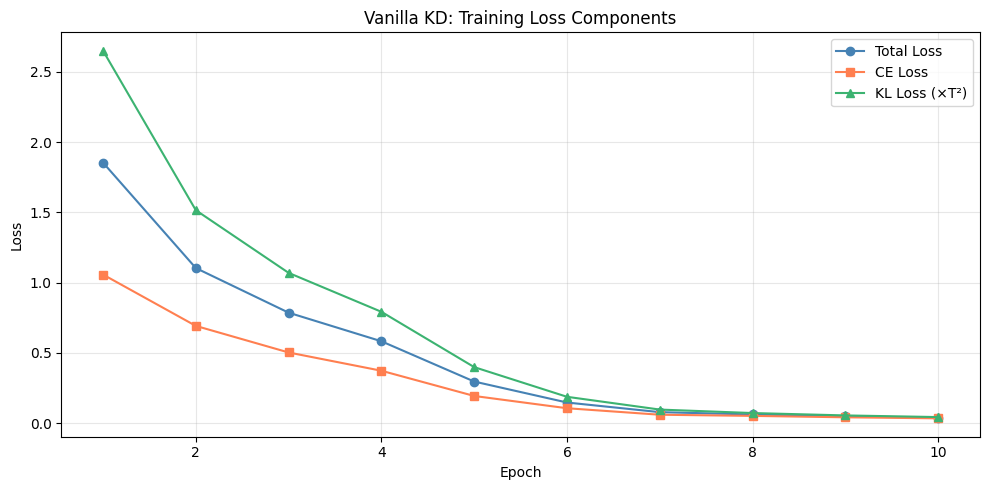

In [15]:
# ── Section 3a-ii: Vanilla KD Loss Curves ────────────────────────────────────
# Shows how each loss component evolves during training.
# Total = α·T²·KL + (1−α)·CE. KL should decrease as the student learns
# to match the teacher's output distributions.

import pandas as pd, matplotlib.pyplot as plt, os

log_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'logs', 'vanilla_kd_training.csv'))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(log_df['epoch'], log_df['train_total_loss'], 'o-', color='steelblue',     label='Total Loss')
ax.plot(log_df['epoch'], log_df['train_ce_loss'],    's-', color='coral',          label='CE Loss')
ax.plot(log_df['epoch'], log_df['train_kl_loss'],    '^-', color='mediumseagreen', label='KL Loss (×T²)')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Vanilla KD: Training Loss Components')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [16]:
# ── Section 3a-iii: Teacher vs. Student (Vanilla KD) Comparison ──────────────
# Compares key metrics between the teacher and the vanilla KD student.
# The student should be much smaller with a modest F1 drop.

import json, os

def load_info(ckpt_dir_name):
    p = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', ckpt_dir_name, 'checkpoint_info.json')
    with open(p) as f: return json.load(f)

teacher_info = load_info('teacher')
vanilla_info = load_info('student_vanilla_kd')

rows = [('Teacher (FinBERT, FP32)', teacher_info),
        ('Student — Vanilla KD',    vanilla_info)]

print(f"\n{'Model':<30} {'Val Macro F1':>14} {'Params (M)':>12} {'Size (MB)':>11}")
print("-" * 70)
for name, info in rows:
    f1     = info.get('val_macro_f1', 0)
    params = info.get('num_parameters', 0) / 1e6
    size   = info.get('size_mb', 0)
    print(f"{name:<30} {f1:>14.4f} {params:>12.1f} {size:>11.1f}")

t_f1 = teacher_info.get('val_macro_f1', 0)
v_f1 = vanilla_info.get('val_macro_f1', 0)
t_sz = teacher_info.get('size_mb', 1)
v_sz = vanilla_info.get('size_mb', 1)
print(f"\n  F1 gap:             {v_f1 - t_f1:+.4f}")
print(f"  Size compression:   {t_sz / v_sz:.1f}×")


Model                            Val Macro F1   Params (M)   Size (MB)
----------------------------------------------------------------------
Teacher (FinBERT, FP32)                0.8876        109.5       437.9
Student — Vanilla KD                   0.8017         19.0        76.1

  F1 gap:             -0.0859
  Size compression:   5.8×


### 3b — Intermediate KD (Hidden States + Attention Supervision)

Vanilla KD only supervises the final output logits. The student is free to build entirely different internal representations as long as the final distribution matches. Intermediate distillation adds two additional supervision signals:

1. **Hidden state MSE:** `L_hidden = MSE(proj(student_hidden_i), teacher_hidden_j)` — a trainable linear projection maps the student's 384-dim vectors to 768-dim before comparing with the teacher's hidden states. This forces the student to develop similar intermediate representations.

2. **Attention pattern MSE:** `L_attn = MSE(student_attn_i, teacher_attn_j)` — forces the student's attention heads to focus on the same parts of the sequence as the teacher's corresponding heads.

**Layer mapping** `{student_layer → teacher_layer}` = `{0→2, 1→5, 2→8, 3→11}` — each of the student's 4 layers is paired with an evenly spaced teacher layer, ensuring coverage of early (syntactic), middle (semantic), and final (task-specific) representations.

**Total loss:** `L = α·T²·KL + (1−α)·CE + λ₁·L_hidden + λ₂·L_attn`

> ⏱️ **~30–45 minutes on T4 GPU.** Checkpoint saved to `fincompress/checkpoints/student_intermediate_kd/`.

In [17]:
# ── Section 3b-i: Train Intermediate KD Student ──────────────────────────────
# Adds hidden state MSE + attention pattern MSE on top of vanilla KD.
# Logs: fincompress/logs/intermediate_kd_training.csv
# Output: fincompress/checkpoints/student_intermediate_kd/

!python -m fincompress.distillation.intermediate_distillation

2026-03-01 01:42:31.245001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772329351.264823   18284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772329351.270916   18284 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772329351.286200   18284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772329351.286224   18284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772329351.286227   18284 computation_placer.cc:177] computation placer alr

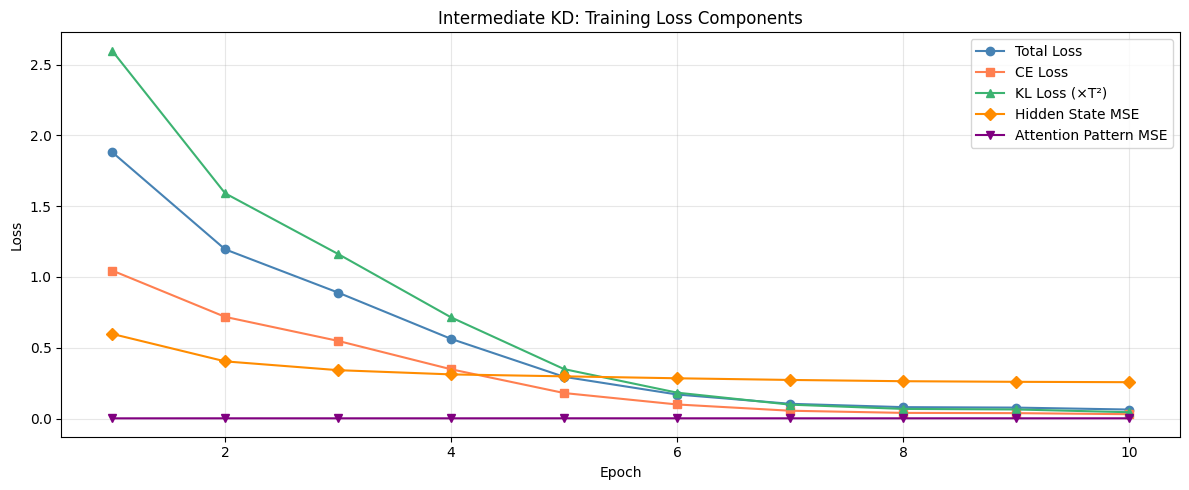

In [18]:
# ── Section 3b-ii: Intermediate KD Loss Curves ───────────────────────────────
# Shows all 5 loss components: total, CE, KL, hidden MSE, attention MSE.
# Hidden and attention losses should decrease as the student's internals
# align with the teacher's.

import pandas as pd, matplotlib.pyplot as plt, os

log_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'logs', 'intermediate_kd_training.csv'))

fig, ax = plt.subplots(figsize=(12, 5))
styles = [
    ('train_total_loss',  'o-', 'steelblue',     'Total Loss'),
    ('train_ce_loss',     's-', 'coral',          'CE Loss'),
    ('train_kl_loss',     '^-', 'mediumseagreen', 'KL Loss (×T²)'),
    ('train_hidden_loss', 'D-', 'darkorange',     'Hidden State MSE'),
    ('train_attn_loss',   'v-', 'purple',         'Attention Pattern MSE'),
]
for col, style, color, label in styles:
    if col in log_df.columns:
        ax.plot(log_df['epoch'], log_df[col], style, color=color, label=label)

ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Intermediate KD: Training Loss Components')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

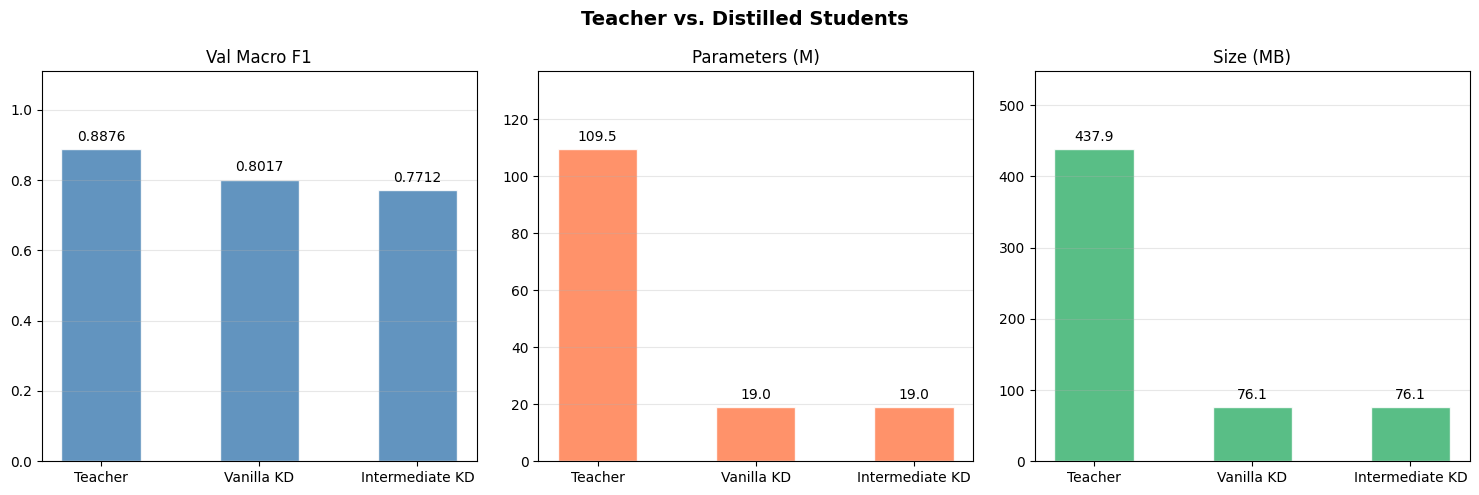

In [19]:
# ── Section 3b-iii: 3-Way Distillation Comparison ────────────────────────────
# Compares teacher, vanilla KD student, and intermediate KD student
# across Val Macro F1, parameter count, and model size.

import json, os, numpy as np, matplotlib.pyplot as plt

def load_info(ckpt_dir_name):
    p = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', ckpt_dir_name, 'checkpoint_info.json')
    with open(p) as f: return json.load(f)

infos = {
    'Teacher':          load_info('teacher'),
    'Vanilla KD':       load_info('student_vanilla_kd'),
    'Intermediate KD':  load_info('student_intermediate_kd'),
}

names  = list(infos.keys())
f1s    = [v.get('val_macro_f1', 0)            for v in infos.values()]
params = [v.get('num_parameters', 0) / 1e6    for v in infos.values()]
sizes  = [v.get('size_mb', 0)                 for v in infos.values()]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, values, title, color, fmt in zip(
    axes,
    [f1s, params, sizes],
    ['Val Macro F1', 'Parameters (M)', 'Size (MB)'],
    ['steelblue', 'coral', 'mediumseagreen'],
    ['.4f', '.1f', '.1f'],
):
    bars = ax.bar(names, values, color=color, alpha=0.85, edgecolor='white', width=0.5)
    ax.bar_label(bars, labels=[f'{v:{fmt}}' for v in values], padding=4, fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylim(0, max(values) * 1.25)
    ax.grid(True, axis='y', alpha=0.3)

fig.suptitle('Teacher vs. Distilled Students', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

---
## Section 4 — Quantization

Quantization reduces weight (and optionally activation) precision from 32-bit float (FP32) to 8-bit integer (INT8), cutting model size by ~4× and often speeding up CPU inference via integer arithmetic units.

### 4a — Post-Training Quantization (PTQ)

**Dynamic PTQ** (our approach): weights are statically quantized to INT8; activations are computed in FP32 but dequantized after each linear layer at runtime. No retraining required — the existing weights are simply rescaled.

**Why dynamic (not static)?** The student model uses raw `torch.matmul(Q, K.T)` in its attention code, which doesn't accept pre-quantized tensor inputs. Static PTQ would require refactoring the forward pass.

**Backend: `fbgemm`** — Facebook's General Matrix Multiplication library, optimised for x86 CPUs. Use `qnnpack` for ARM/mobile targets.

**What stays FP32:**
- **Embeddings** — INT8 lookup tables provide no GEMM speedup
- **Classifier head** — too small to benefit; keeping FP32 preserves final-layer precision

> ⏱️ **~5 minutes** (no GPU needed). Checkpoint saved to `fincompress/checkpoints/student_ptq/`.

In [20]:
# ── Section 4a-i: Run Post-Training Quantization ─────────────────────────────
# Applies dynamic INT8 quantization to the intermediate KD student.
# No training required — weights are rescaled and converted.
# Output: fincompress/checkpoints/student_ptq/

!python -m fincompress.quantization.ptq

Running PTQ (dynamic) on CPU
Loading student from /content/drive/MyDrive/fincompress/fincompress/checkpoints/student_intermediate_kd...
FP32 model size: 76.1 MB
FP32 baseline val Macro F1: 0.7712

Evaluating quantized model...

PTQ Results:
  FP32 size:          76.1 MB
  INT8 size:          47.7 MB
  Compression ratio:  1.6×
  FP32 val F1:        0.7712
  INT8 val F1:        0.7712
  F1 drop:            +0.0000

Checkpoint saved to: /content/drive/MyDrive/fincompress/fincompress/checkpoints/student_ptq


In [21]:
# ── Section 4a-ii: FP32 vs. INT8 (PTQ) Comparison ───────────────────────────
# Shows the accuracy cost and size benefit of INT8 quantization.
# A F1 drop < 0.02 (2%) is generally acceptable for production use.

import json, os

def load_info(ckpt_dir_name):
    p = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', ckpt_dir_name, 'checkpoint_info.json')
    with open(p) as f: return json.load(f)

fp32_info = load_info('student_intermediate_kd')
ptq_info  = load_info('student_ptq')

fp32_f1, fp32_sz = fp32_info.get('val_macro_f1', 0), fp32_info.get('size_mb', 0)
ptq_f1,  ptq_sz  = ptq_info.get('val_macro_f1', 0),  ptq_info.get('size_mb', 0)

print(f"\n{'Model':<35} {'Val Macro F1':>14} {'Size (MB)':>11} {'Compression':>13}")
print("-" * 76)
print(f"{'Student (FP32 — Intermediate KD)':<35} {fp32_f1:>14.4f} {fp32_sz:>11.1f} {'1.0×':>13}")
print(f"{'Student (INT8 — PTQ)':<35} {ptq_f1:>14.4f} {ptq_sz:>11.1f} {fp32_sz/max(ptq_sz,0.01):>12.1f}×")
print(f"\n  F1 change:      {ptq_f1 - fp32_f1:+.4f}")
print(f"  Size reduction: {(1 - ptq_sz/max(fp32_sz,0.01))*100:.1f}%")
print(f"  Decision rule:  {'✅ PTQ is acceptable (drop < 2%)' if abs(ptq_f1 - fp32_f1) < 0.02 else '⚠️  PTQ drops > 2% — consider QAT'}")


Model                                 Val Macro F1   Size (MB)   Compression
----------------------------------------------------------------------------
Student (FP32 — Intermediate KD)            0.7712        76.1          1.0×
Student (INT8 — PTQ)                        0.7712        47.7          1.6×

  F1 change:      +0.0000
  Size reduction: 37.3%
  Decision rule:  ✅ PTQ is acceptable (drop < 2%)


### 4b — Quantization-Aware Training (QAT)

QAT inserts **fake-quantization nodes** into the model *during training*. These simulate INT8 rounding in the forward pass so the model learns weights that are robust to quantization, while still allowing real-valued gradients to flow backward (via the **straight-through estimator, STE**: gradients pass through the rounding operation as if it were the identity).

The model is fine-tuned for 3 epochs with fake-quant active, then converted to true INT8 for inference — recovering 1–2% accuracy lost by PTQ.

**When to use QAT vs. PTQ:**
- PTQ drops < 2% F1 → use PTQ (free, no training cost)
- PTQ drops ≥ 2% F1 → use QAT (3 epochs to recover accuracy)

> ⏱️ **~20–30 minutes on T4 GPU.** Checkpoint saved to `fincompress/checkpoints/student_qat/`.

In [22]:
# ── Section 4b-i: Quantization-Aware Training ────────────────────────────────
# Fine-tunes the INT8-quantized student for 3 epochs with fake-quant nodes.
# Logs: fincompress/logs/qat_training.csv
# Output: fincompress/checkpoints/student_qat/

!python -m fincompress.quantization.qat

Using device: cuda
WandB disabled (no WANDB_API_KEY found). Training metrics logged to CSV only.
Loading student from /content/drive/MyDrive/fincompress/fincompress/checkpoints/student_intermediate_kd...
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Starting QAT for 3 epochs...

Epoch  Train Loss   Val F1
----------------------------
QAT Epoch 1/3:   0% 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/usr/local/lib/python3.12/dist-packag

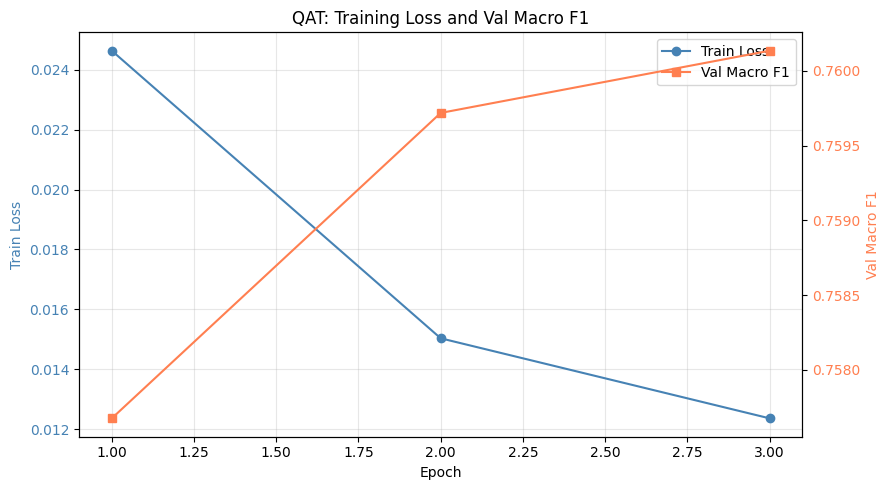

In [23]:
# ── Section 4b-ii: QAT Training Curves ──────────────────────────────────────
# Dual-axis plot: train loss (left) and val Macro F1 (right) over QAT epochs.
# F1 should recover toward the FP32 baseline over the 3 fine-tuning epochs.

import pandas as pd, matplotlib.pyplot as plt, os

log_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'logs', 'qat_training.csv'))

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(log_df['epoch'], log_df['train_loss'], 'o-', color='steelblue', label='Train Loss')
ax2.plot(log_df['epoch'], log_df['val_f1'],     's-', color='coral',     label='Val Macro F1')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='steelblue'); ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.set_ylabel('Val Macro F1', color='coral');   ax2.tick_params(axis='y', labelcolor='coral')
ax1.set_title('QAT: Training Loss and Val Macro F1')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [24]:
# ── Section 4b-iii: FP32 vs PTQ vs QAT 3-Way Comparison ─────────────────────
# Compares the three quantization variants.
# QAT should recover some or all of the F1 lost by PTQ.

import json, os

def load_info(ckpt_dir_name):
    p = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', ckpt_dir_name, 'checkpoint_info.json')
    with open(p) as f: return json.load(f)

fp32_info = load_info('student_intermediate_kd')
ptq_info  = load_info('student_ptq')
qat_info  = load_info('student_qat')

rows = [('Student (FP32 — Intermediate KD)', fp32_info),
        ('Student (INT8 — PTQ)',              ptq_info),
        ('Student (INT8 — QAT)',              qat_info)]

print(f"\n{'Model':<35} {'Val Macro F1':>14} {'Size (MB)':>11}")
print("-" * 63)
for name, info in rows:
    f1   = info.get('val_macro_f1', 0)
    size = info.get('size_mb', 0)
    print(f"{name:<35} {f1:>14.4f} {size:>11.1f}")

fp32_f1 = fp32_info.get('val_macro_f1', 0)
ptq_f1  = ptq_info.get('val_macro_f1', 0)
qat_f1  = qat_info.get('val_macro_f1', 0)
print(f"\n  PTQ F1 change vs FP32: {ptq_f1 - fp32_f1:+.4f}")
print(f"  QAT F1 change vs FP32: {qat_f1 - fp32_f1:+.4f}")
print(f"  QAT recovery over PTQ: {qat_f1 - ptq_f1:+.4f}")


Model                                 Val Macro F1   Size (MB)
---------------------------------------------------------------
Student (FP32 — Intermediate KD)            0.7712        76.1
Student (INT8 — PTQ)                        0.7712        47.7
Student (INT8 — QAT)                        0.7601        47.7

  PTQ F1 change vs FP32: +0.0000
  QAT F1 change vs FP32: -0.0111
  QAT recovery over PTQ: -0.0111


---
## Section 5 — Structured Pruning

Pruning removes parameters from a trained model. There are two main approaches:

- **Unstructured pruning:** Zero out individual weights → sparse matrix. Requires specialised sparse-matrix kernels to see real inference speedup (standard hardware doesn't accelerate sparse ops natively).
- **Structured pruning (our approach):** Remove entire attention heads or FFN neuron groups → smaller, *dense* matrices. Hardware-friendly — no specialised kernels needed.

**Why can we prune so much?** Large pre-trained models are heavily over-parameterised. Research shows 30–50% of BERT attention heads are redundant on downstream classification tasks — some heads attend to similar patterns, others to uninformative tokens like punctuation.

**Head importance scoring (entropy-based):**
```
importance = 1 − normalised_entropy(attention_weights)
```
A head that always attends sharply to a few tokens (low entropy, focused) is *important*. A head with near-uniform attention across all tokens (high entropy, diffuse) is *prunable*.

**Iterative prune + recover loop:**
1. Prune the lowest-importance 10% of heads
2. Fine-tune for 1 epoch to let remaining heads adapt
3. Repeat until target sparsity reached

Saves `pruned_teacher_30pct` and `pruned_teacher_50pct` checkpoints.

> ⏱️ **~60–90 minutes on T4 GPU.**

In [25]:
# ── Section 5a: Iterative Prune + Recover ────────────────────────────────────
# Prunes teacher attention heads iteratively (10% at a time) with 1-epoch
# recovery fine-tuning after each pruning step.
# Outputs: fincompress/checkpoints/pruned_teacher_30pct/
#          fincompress/checkpoints/pruned_teacher_50pct/
#          fincompress/results/pruning_curve.csv

!python -m fincompress.pruning.prune_finetune

Using device: cuda
WandB disabled (no WANDB_API_KEY found). Training metrics logged to CSV only.
Loading teacher from /content/drive/MyDrive/fincompress/fincompress/checkpoints/teacher...
Baseline val Macro F1: 0.8876

Pruning Round 1/5
  Computing head importance...
  Pruning 14 heads (cumulative: 14/144 = 9.7%)
  Fine-tuning for 3 recovery epochs...
  Round 1 | Heads pruned: 14 | Sparsity: 9.7% | Val F1: 0.8818 | ΔF1: -0.0058

Pruning Round 2/5
  Computing head importance...
  Pruning 14 heads (cumulative: 28/144 = 19.4%)
  Fine-tuning for 3 recovery epochs...
  Round 2 | Heads pruned: 14 | Sparsity: 19.4% | Val F1: 0.8905 | ΔF1: +0.0088

Pruning Round 3/5
  Computing head importance...
  Pruning 14 heads (cumulative: 42/144 = 29.2%)
  Fine-tuning for 3 recovery epochs...
  Round 3 | Heads pruned: 14 | Sparsity: 29.2% | Val F1: 0.8966 | ΔF1: +0.0061
  → Saving pruned_teacher_30pct checkpoint (29.2% sparsity)

Pruning Round 4/5
  Computing head importance...
  Pruning 14 heads (cumula

**Reading the head importance heatmap below:**

Each cell shows the importance score (0–1) for one attention head in one layer. Brighter = more important. Look for:
- **Dark columns:** entire heads that are redundant across all layers (safe to prune)
- **Dark rows:** layers where most heads are dispensable
- **Bright cells in the final layer:** task-specific heads the model needs for classification

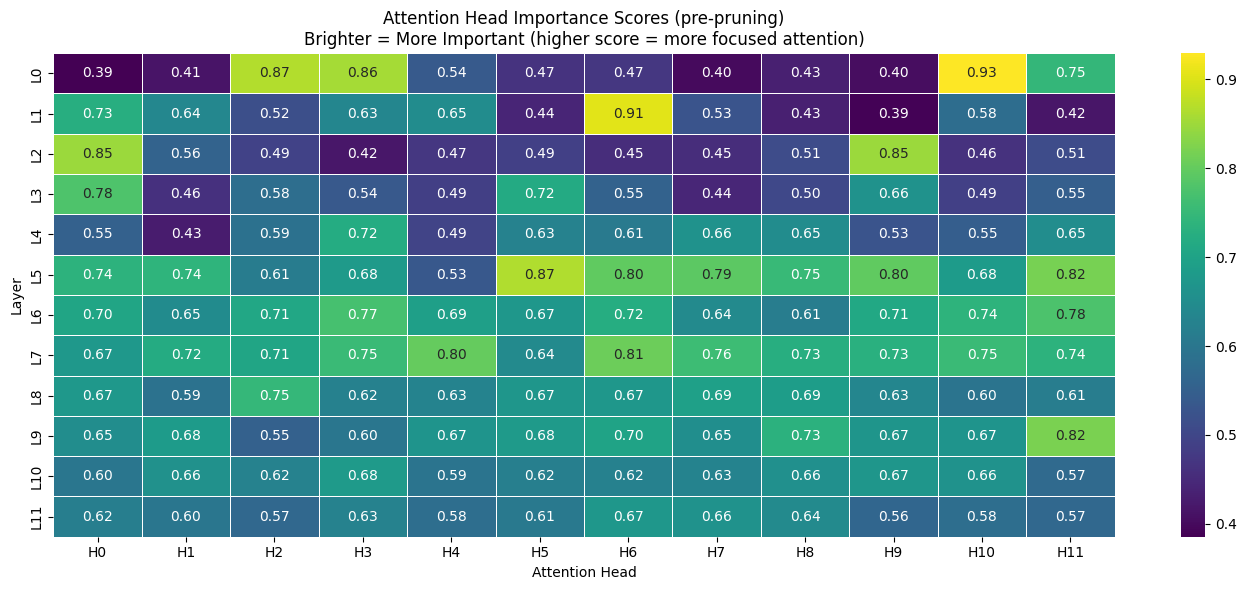

In [26]:
# ── Section 5b: Attention Head Importance Heatmap ────────────────────────────
# Computes entropy-based importance scores for every attention head in the
# teacher model, then visualises them as a [layers × heads] heatmap.
# Brighter = more important (lower entropy = more focused attention).

import torch, os, numpy as np
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset

class FinDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts  = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], max_length=self.max_len,
                       padding='max_length', truncation=True, return_tensors='pt')
        return {'input_ids':      enc['input_ids'].squeeze(0),
                'attention_mask': enc['attention_mask'].squeeze(0),
                'token_type_ids': enc.get('token_type_ids',
                    torch.zeros(self.max_len, dtype=torch.long)).squeeze(0),
                'label':          torch.tensor(self.labels[i])}

device    = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt_dir  = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints', 'teacher')
tokenizer = AutoTokenizer.from_pretrained(os.path.join(ckpt_dir, 'tokenizer'))
teacher   = AutoModelForSequenceClassification.from_pretrained(ckpt_dir).to(device)
teacher.eval()

df_val = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'data', 'val.csv'))
loader = DataLoader(FinDataset(df_val, tokenizer, 128), batch_size=32)

num_layers = teacher.config.num_hidden_layers
num_heads  = teacher.config.num_attention_heads
importance = np.zeros((num_layers, num_heads))

with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= 30: break
        out = teacher(batch['input_ids'].to(device),
                      attention_mask=batch['attention_mask'].to(device),
                      output_attentions=True)
        for layer_idx, attn in enumerate(out.attentions):
            eps     = 1e-9
            entropy = -(attn * (attn + eps).log()).sum(dim=-1).mean(dim=-1)  # [B, heads]
            max_ent = np.log(batch['input_ids'].shape[1])
            importance[layer_idx] += (1 - entropy / (max_ent + eps)).mean(dim=0).cpu().numpy()

importance /= min(30, len(loader))

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(importance, annot=True, fmt='.2f', cmap='viridis', linewidths=0.5,
            xticklabels=[f'H{i}' for i in range(num_heads)],
            yticklabels=[f'L{i}' for i in range(num_layers)], ax=ax)
ax.set_xlabel('Attention Head'); ax.set_ylabel('Layer')
ax.set_title('Attention Head Importance Scores (pre-pruning)\nBrighter = More Important (higher score = more focused attention)')
plt.tight_layout(); plt.show()

**Reading the pruning curve below:**

The x-axis shows what percentage of attention heads have been removed. The y-axis shows val Macro F1 at that sparsity level. The **red dashed line** marks the "cliff" — the point where F1 drops more than 0.02 below its peak. Pruning beyond the cliff causes disproportionate quality loss as important heads start being removed.

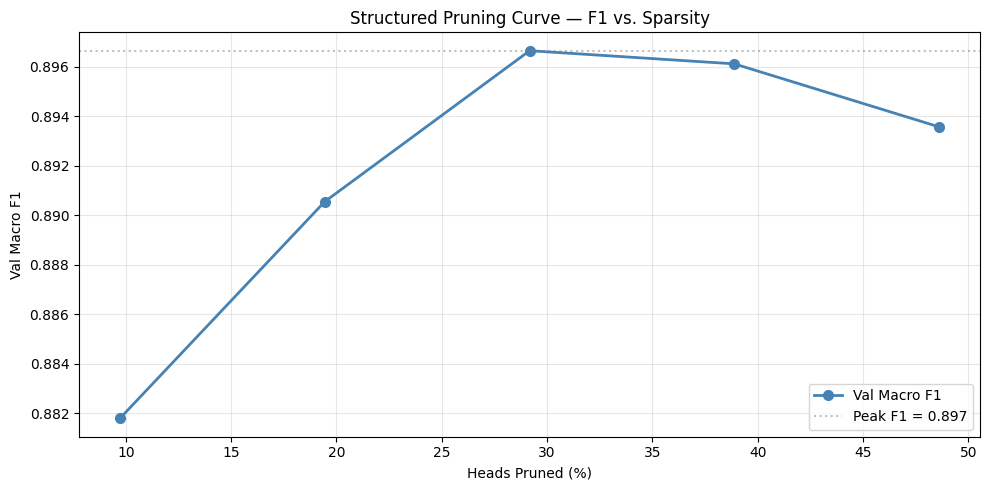

In [27]:
# ── Section 5c: Pruning Curve with Cliff Detection ───────────────────────────
# Plots F1 vs. sparsity. Detects and marks the "cliff" — the point where
# removing more heads starts causing disproportionate accuracy loss.

import pandas as pd, matplotlib.pyplot as plt, os

curve_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'results', 'pruning_curve.csv'))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(curve_df['heads_pruned_pct'], curve_df['val_f1'], 'o-',
        color='steelblue', linewidth=2, markersize=7, label='Val Macro F1')

peak_f1  = curve_df['val_f1'].max()
cliff_thr = peak_f1 - 0.02
cliff_row = curve_df[curve_df['val_f1'] < cliff_thr].head(1)

if not cliff_row.empty:
    cliff_pct = cliff_row['heads_pruned_pct'].values[0]
    ax.axvline(x=cliff_pct, color='red', linestyle='--', linewidth=1.5,
               label=f'Cliff @ {cliff_pct:.0f}% pruned')
    ax.axvspan(cliff_pct, curve_df['heads_pruned_pct'].max(), alpha=0.08, color='red')
    ax.annotate(f'Cliff ({cliff_pct:.0f}%)', xy=(cliff_pct, cliff_thr),
                xytext=(cliff_pct + 5, cliff_thr - 0.01),
                arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=10)

ax.axhline(y=peak_f1, color='gray', linestyle=':', alpha=0.5,
           label=f'Peak F1 = {peak_f1:.3f}')
ax.set_xlabel('Heads Pruned (%)'); ax.set_ylabel('Val Macro F1')
ax.set_title('Structured Pruning Curve — F1 vs. Sparsity')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [28]:
# ── Section 5d: Pruning Results Table ────────────────────────────────────────
# Full numeric table: sparsity level, val F1, and delta from peak F1.

import pandas as pd, os

curve_df = pd.read_csv(os.path.join(PROJECT_PATH, 'fincompress', 'results', 'pruning_curve.csv'))
peak_f1  = curve_df['val_f1'].max()
peak_pct = curve_df.loc[curve_df['val_f1'].idxmax(), 'heads_pruned_pct']

print(f"\n{'Heads Pruned':>14} {'Val Macro F1':>14} {'Δ vs Peak':>12}")
print("-" * 43)
for _, row in curve_df.iterrows():
    delta = row['val_f1'] - peak_f1
    print(f"{row['heads_pruned_pct']:>13.0f}% {row['val_f1']:>14.4f} {delta:>12.4f}")

print(f"\nPeak F1:  {peak_f1:.4f}  @ {peak_pct:.0f}% pruned")
print(f"Final F1: {curve_df['val_f1'].iloc[-1]:.4f}  @ {curve_df['heads_pruned_pct'].iloc[-1]:.0f}% pruned")
print(f"Total F1 drop: {curve_df['val_f1'].iloc[-1] - peak_f1:+.4f}")


  Heads Pruned   Val Macro F1    Δ vs Peak
-------------------------------------------
           10%         0.8818      -0.0149
           19%         0.8905      -0.0061
           29%         0.8966       0.0000
           39%         0.8961      -0.0005
           49%         0.8936      -0.0031

Peak F1:  0.8966  @ 29% pruned
Final F1: 0.8936  @ 49% pruned
Total F1 drop: -0.0031


**Interpretation:**
- **Surviving heads** (high importance scores) tend to cluster in lower layers (capturing syntactic structure) and the final layer (task-specific classification signal).
- **Prunable heads** are often in middle layers — these appear to encode redundant syntactic patterns already captured elsewhere in the model.
- The **cliff behaviour** is characteristic of structured pruning: the model is robust to losing redundant heads, but once heads carrying unique information are removed, performance collapses rapidly.
- **30% sparsity** is typically safe for BERT-family models on classification tasks. 50% sparsity often requires more careful recovery fine-tuning.

---
## Section 6 — Benchmarking All 7 Variants

Now that all compression techniques are applied, we run a unified benchmark across all 7 model variants:
1. `teacher` — FinBERT fine-tuned (FP32, 12 layers)
2. `student_vanilla_kd` — 4-layer student via soft-label KD
3. `student_intermediate_kd` — 4-layer student via intermediate KD
4. `student_ptq` — INT8 post-training quantization
5. `student_qat` — INT8 quantization-aware training
6. `pruned_teacher_30pct` — Teacher with 30% heads removed
7. `pruned_teacher_50pct` — Teacher with 50% heads removed

**Metrics:**
- **Test Macro F1** and accuracy on the held-out test set
- **Median CPU latency** with 50 warmup samples, then median over 500 samples
- **Throughput** in samples/second

**Why median latency (not mean)?** CPU latency distributions are right-skewed — rare GC pauses and cache misses create extreme outliers. The median is more representative of typical inference behaviour.

> ⏱️ **~10–15 minutes.** Results saved to `fincompress/results/benchmark_results.json` and `benchmark_results.csv`.

In [29]:
# ── Section 6a: Run Unified Benchmark ────────────────────────────────────────
# Loads all 7 model checkpoints and evaluates them on the test set.
# Measures accuracy, Macro F1, median CPU latency, and throughput.
# Output: fincompress/results/benchmark_results.json + .csv

!python -m fincompress.evaluation.benchmark

FinCompress — Master Benchmark
Device: cpu
Warmup runs: 50 | Timed runs: 500

[teacher]
  Parameters: 109,484,547  |  Size: 437.9 MB
  Evaluating accuracy on test set...
  Macro F1: 0.9182  |  Accuracy: 0.9269
  Measuring latency (50 warmup + 500 timed)...
  Latency — median: 286.88 ms  |  p95: 397.28 ms
  Throughput: 4.3 samples/sec

[student_vanilla_kd]
  Parameters: 19,017,603  |  Size: 76.1 MB
  Evaluating accuracy on test set...
  Macro F1: 0.7713  |  Accuracy: 0.7945
  Measuring latency (50 warmup + 500 timed)...
  Latency — median: 24.20 ms  |  p95: 37.72 ms
  Throughput: 47.8 samples/sec

[student_intermediate_kd]
  Parameters: 19,017,603  |  Size: 76.1 MB
  Evaluating accuracy on test set...
  Macro F1: 0.7881  |  Accuracy: 0.8123
  Measuring latency (50 warmup + 500 timed)...
  Latency — median: 24.06 ms  |  p95: 35.55 ms
  Throughput: 46.1 samples/sec

[student_ptq]
/usr/local/lib/python3.12/dist-packages/torch/_utils.py:383: UserWarning: TypedStorage is deprecated. It will 

In [30]:
# ── Section 6b: Benchmark Results Table ──────────────────────────────────────
# Loads and pretty-prints the benchmark results CSV.

import pandas as pd, os

results_path = os.path.join(PROJECT_PATH, 'fincompress', 'results', 'benchmark_results.csv')
df = pd.read_csv(results_path)

priority_cols = ['model', 'accuracy', 'macro_f1', 'size_mb',
                 'cpu_latency_ms_median', 'throughput_samples_per_sec']
cols = [c for c in priority_cols if c in df.columns]

df_show = df[cols].copy()
df_show.columns = [c.replace('_', ' ').title() for c in cols]

print("\n" + "=" * 90)
print("FinCompress — Final Benchmark Results")
print("=" * 90)
print(df_show.to_string(index=False, float_format='{:.4f}'.format))
print("=" * 90)


FinCompress — Final Benchmark Results
 Accuracy  Macro F1  Size Mb  Cpu Latency Ms Median
   0.9269    0.9182 437.9500               286.8790
   0.7945    0.7713  76.0700                24.2030
   0.8123    0.7881  76.0700                24.0610
   0.8103    0.7864  47.7000                19.8270
   0.7866    0.7621  47.7000                20.1940
   0.9308    0.9215 437.9500               266.3750
   0.9229    0.9125 437.9500               263.5170


---
## Section 7 — Analysis & Publication-Quality Plots

We generate 6 plots that summarise the compression study end-to-end:

| Plot | What it shows |
|------|--------------|
| **Pareto** | Accuracy vs. latency trade-off. Bubble size = model size. Top-left corner is better. |
| **Compression bar** | Size, latency, and F1 normalised to teacher baseline (< 1.0 = compressed) |
| **Latency distribution** | Box plots of raw latency measurements — reveals spread and outliers |
| **F1 degradation** | How much Macro F1 each compression technique costs (green < 2%, orange 2–5%, red > 5%) |
| **Pruning curve** | F1 vs. sparsity with cliff detection |
| **KD loss curves** | Vanilla vs. intermediate distillation loss components side by side |

All plots are saved to `fincompress/results/plots/`.

In [32]:
# ── Section 7: Plot Setup ─────────────────────────────────────────────────────
# Load benchmark results and configure plotting environment.

import os, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
FIGSIZE = (10, 6)
DPI     = 150

RESULTS_DIR = Path(PROJECT_PATH) / 'fincompress' / 'results'
PLOTS_DIR   = RESULTS_DIR / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(RESULTS_DIR / 'benchmark_results.csv')
print(f"Loaded {len(df)} variants. Plots will be saved to: {PLOTS_DIR}")
print(df[['model_name', 'macro_f1', 'size_mb']].to_string(index=False))

Loaded 7 variants. Plots will be saved to: /content/drive/MyDrive/fincompress/fincompress/results/plots
             model_name  macro_f1  size_mb
                teacher  0.918242   437.95
     student_vanilla_kd  0.771319    76.07
student_intermediate_kd  0.788139    76.07
            student_ptq  0.786407    47.70
            student_qat  0.762133    47.70
   pruned_teacher_30pct  0.921500   437.95
   pruned_teacher_50pct  0.912469   437.95


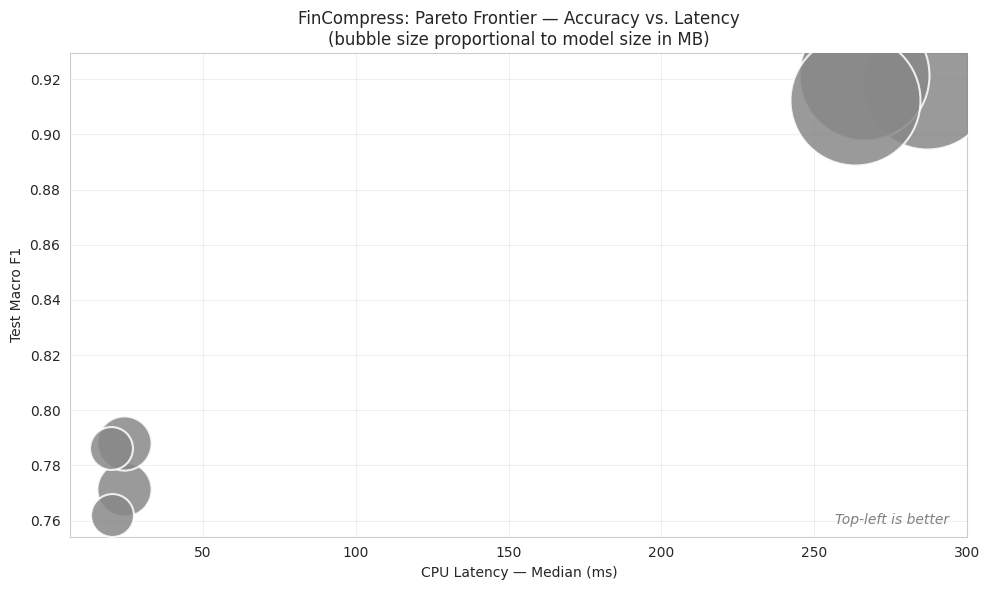

Saved: pareto_plot.png


In [33]:
# ── Section 7a: Plot 1 — Pareto Frontier ─────────────────────────────────────
# Accuracy vs. latency scatter plot. Bubble size = model size.
# Points toward the top-left are better (higher F1, lower latency).

color_map = {
    'teacher':               '#e63946',
    'student_vanilla':       '#457b9d',
    'student_intermediate':  '#1d3557',
    'student_ptq':           '#2a9d8f',
    'student_qat':           '#264653',
    'pruned_teacher_30pct':  '#e9c46a',
    'pruned_teacher_50pct':  '#f4a261',
}

fig, ax = plt.subplots(figsize=FIGSIZE)
for _, row in df.iterrows():
    model = row.get('model', '')
    x     = row.get('cpu_latency_ms_median', row.get('latency_ms', 0))
    y     = row.get('macro_f1', 0)
    size  = row.get('size_mb', 10) * 20
    color = color_map.get(model, '#888888')
    ax.scatter(x, y, s=size, color=color, alpha=0.85,
               edgecolors='white', linewidth=1.5, zorder=3)
    ax.annotate(model.replace('_', '\n'), (x, y),
                textcoords='offset points', xytext=(8, 4), fontsize=8)

ax.set_xlabel('CPU Latency — Median (ms)')
ax.set_ylabel('Test Macro F1')
ax.set_title('FinCompress: Pareto Frontier — Accuracy vs. Latency\n(bubble size proportional to model size in MB)')
ax.text(0.98, 0.02, 'Top-left is better', transform=ax.transAxes,
        ha='right', va='bottom', style='italic', color='gray')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'pareto_plot.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: pareto_plot.png")

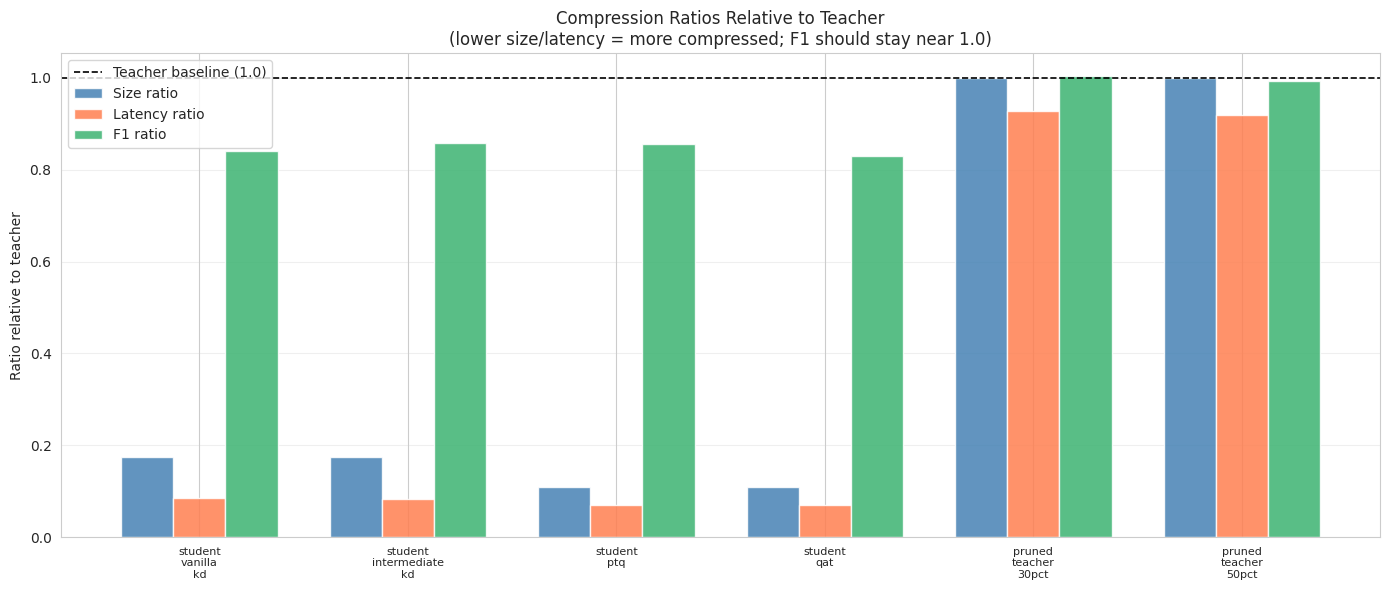

Saved: compression_bar_chart.png


In [36]:
# ── Section 7b: Plot 2 — Compression Bar Chart ───────────────────────────────
# All metrics normalised to teacher = 1.0 baseline.
# Size ratio < 1 = model is smaller. Latency ratio < 1 = model is faster.
# F1 ratio should stay as close to 1.0 as possible.

teacher_row = df[df['model_name'] == 'teacher'].iloc[0]
t_size = teacher_row.get('size_mb', 1)
t_lat  = teacher_row.get('cpu_latency_ms_median', teacher_row.get('latency_ms', 1))
t_f1   = teacher_row.get('macro_f1', 1)

others = df[df['model_name'] != 'teacher']
models_list = others['model_name'].tolist()
rows_list   = [others[others['model_name'] == m].iloc[0] for m in models_list]

size_ratios = [r.get('size_mb', 0) / t_size for r in rows_list]
lat_ratios  = [r.get('cpu_latency_ms_median', r.get('latency_ms', 0)) / t_lat for r in rows_list]
f1_ratios   = [r.get('macro_f1', 0) / t_f1 for r in rows_list]

x     = np.arange(len(models_list)); width = 0.25
fig, ax = plt.subplots(figsize=(14, 6))
b1 = ax.bar(x - width, size_ratios, width, label='Size ratio',    color='steelblue',     alpha=0.85)
b2 = ax.bar(x,         lat_ratios,  width, label='Latency ratio', color='coral',          alpha=0.85)
b3 = ax.bar(x + width, f1_ratios,   width, label='F1 ratio',      color='mediumseagreen', alpha=0.85)
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1.2, label='Teacher baseline (1.0)')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', '\n') for m in models_list], fontsize=8)
ax.set_ylabel('Ratio relative to teacher')
ax.set_title('Compression Ratios Relative to Teacher\n(lower size/latency = more compressed; F1 should stay near 1.0)')
ax.legend(); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'compression_bar_chart.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: compression_bar_chart.png")

/tmp/ipython-input-9357/4008817708.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_latencies,


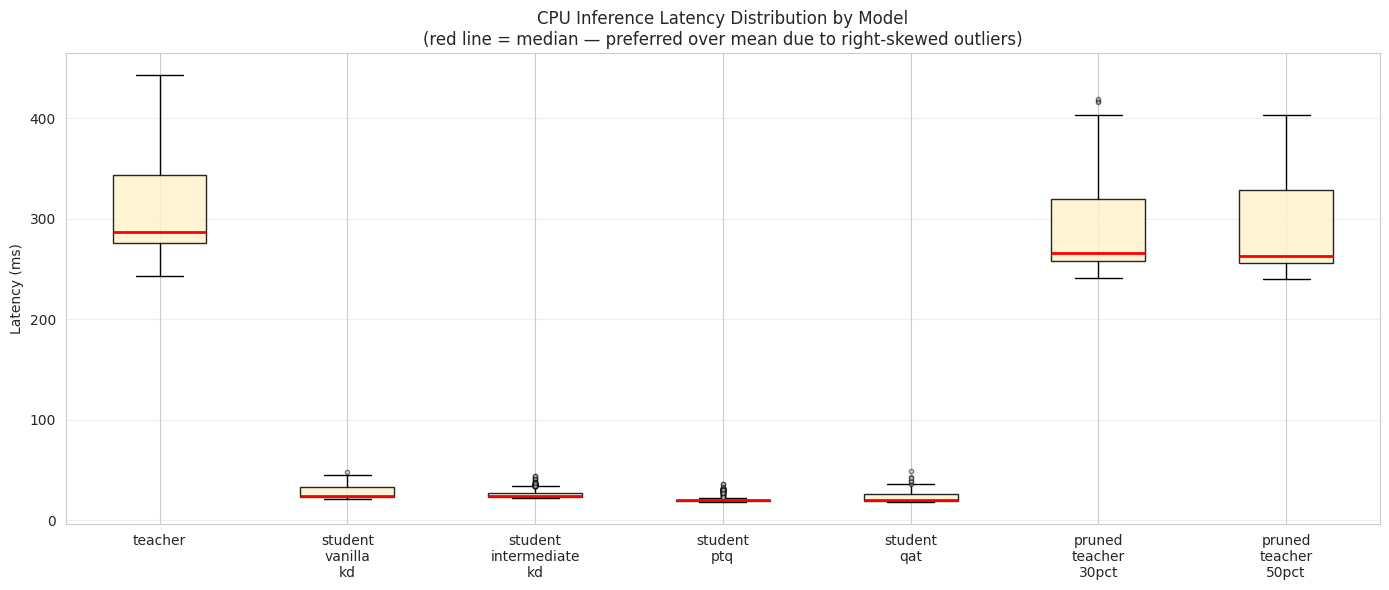

Saved: latency_distribution.png


In [37]:
# ── Section 7c: Plot 3 — Latency Distribution Box Plots ──────────────────────
# Box plots of raw per-sample latency measurements for each model.
# Red line = median. Boxes show IQR. Dots are outliers.
# Right-skewed distributions (long upper tail) explain why we use median not mean.

import json
with open(RESULTS_DIR / 'latency_raw.json') as f:
    latency_raw = json.load(f)

model_names   = list(latency_raw.keys())
all_latencies = [latency_raw[m] for m in model_names]

fig, ax = plt.subplots(figsize=(14, 6))
bp = ax.boxplot(all_latencies,
                labels=[m.replace('_', '\n') for m in model_names],
                patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='lightgray',
                                markersize=3, alpha=0.5))
for patch in bp['boxes']:
    patch.set(facecolor='#fff3cd', alpha=0.85)

ax.set_ylabel('Latency (ms)')
ax.set_title('CPU Inference Latency Distribution by Model\n'
             '(red line = median — preferred over mean due to right-skewed outliers)')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'latency_distribution.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: latency_distribution.png")

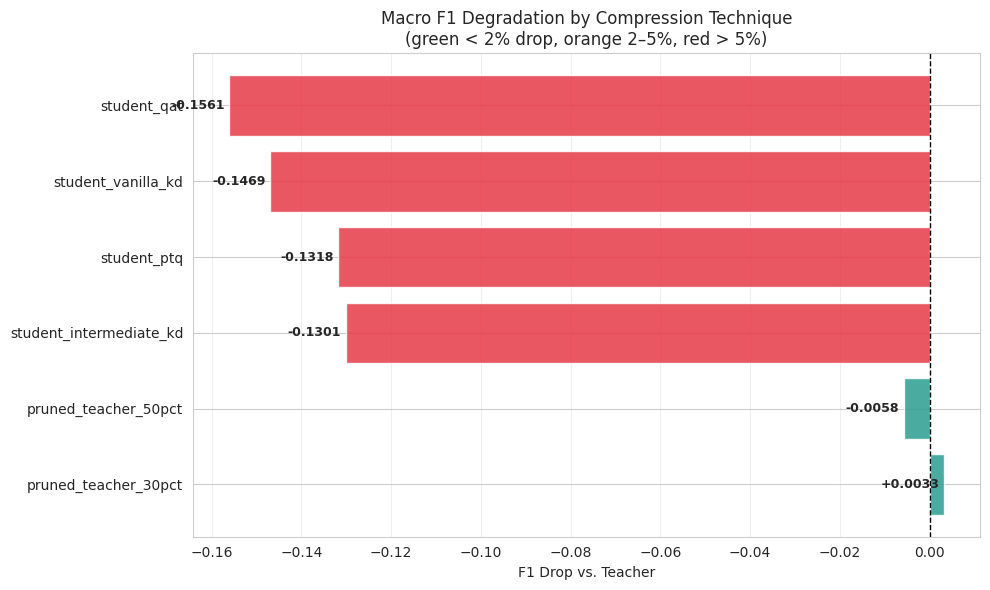

Saved: f1_degradation_bar.png


In [39]:
# ── Section 7d: Plot 4 — F1 Degradation ─────────────────────────────────────
# Horizontal bar chart showing how much each variant drops below the teacher.
# Green: drop < 2% (acceptable), Orange: 2–5% (moderate), Red: > 5% (significant).

teacher_f1  = df[df['model_name'] == 'teacher']['macro_f1'].values[0]
non_teacher = df[df['model_name'] != 'teacher'].copy()
non_teacher['f1_drop'] = non_teacher['macro_f1'] - teacher_f1
non_teacher = non_teacher.sort_values('f1_drop', ascending=False)

def bar_color(drop):
    if   drop > -0.02: return '#2a9d8f'   # green
    elif drop > -0.05: return '#e9c46a'   # orange
    else:              return '#e63946'   # red

colors = [bar_color(d) for d in non_teacher['f1_drop'].tolist()]

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.barh(non_teacher['model_name'], non_teacher['f1_drop'],
        color=colors, alpha=0.85, edgecolor='white')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
for i, (_, row) in enumerate(non_teacher.iterrows()):
    ax.text(row['f1_drop'] - 0.001, i, f"{row['f1_drop']:+.4f}",
            va='center', ha='right', fontsize=9, fontweight='bold')
ax.set_xlabel('F1 Drop vs. Teacher')
ax.set_title('Macro F1 Degradation by Compression Technique\n'
             '(green < 2% drop, orange 2–5%, red > 5%)')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'f1_degradation_bar.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: f1_degradation_bar.png")

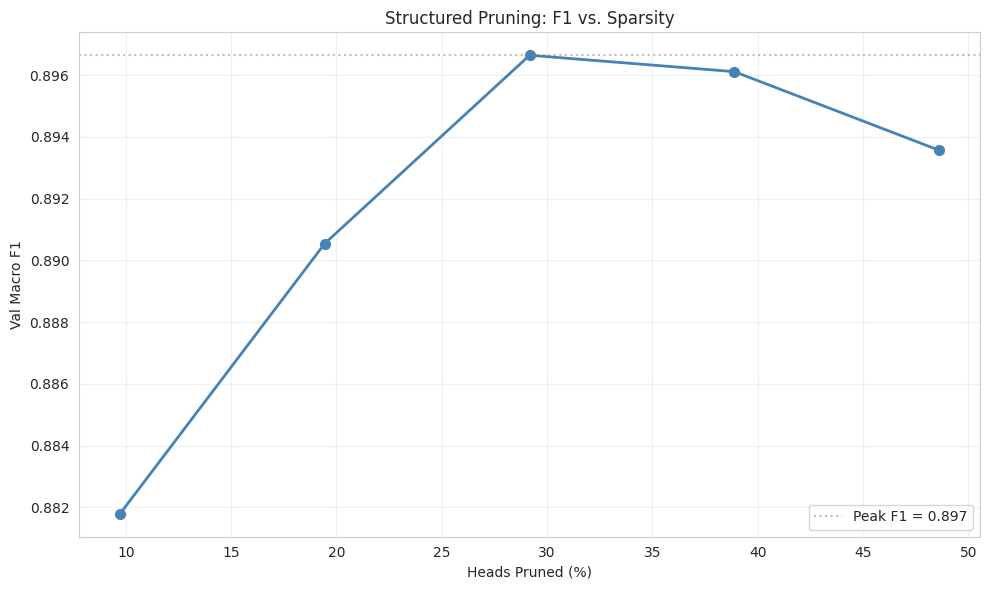

Saved: pruning_curve.png


In [40]:
# ── Section 7e: Plot 5 — Pruning Curve ───────────────────────────────────────
# Same as Section 5c but saves to the plots directory alongside the other figures.

import pandas as pd, matplotlib.pyplot as plt

curve_df  = pd.read_csv(RESULTS_DIR / 'pruning_curve.csv')
peak_f1   = curve_df['val_f1'].max()
cliff_thr = peak_f1 - 0.02

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(curve_df['heads_pruned_pct'], curve_df['val_f1'], 'o-',
        color='steelblue', linewidth=2, markersize=7)

cliff_row = curve_df[curve_df['val_f1'] < cliff_thr].head(1)
if not cliff_row.empty:
    cliff_pct = cliff_row['heads_pruned_pct'].values[0]
    ax.axvline(x=cliff_pct, color='red', linestyle='--',
               label=f'Cliff @ {cliff_pct:.0f}%')
    ax.axvspan(cliff_pct, curve_df['heads_pruned_pct'].max(), alpha=0.08, color='red')
    ax.annotate(f'Cliff ({cliff_pct:.0f}%)', xy=(cliff_pct, cliff_thr),
                xytext=(cliff_pct + 5, cliff_thr - 0.01),
                arrowprops=dict(arrowstyle='->', color='red'), color='red')

ax.axhline(y=peak_f1, color='gray', linestyle=':', alpha=0.5,
           label=f'Peak F1 = {peak_f1:.3f}')
ax.set_xlabel('Heads Pruned (%)'); ax.set_ylabel('Val Macro F1')
ax.set_title('Structured Pruning: F1 vs. Sparsity')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'pruning_curve.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: pruning_curve.png")

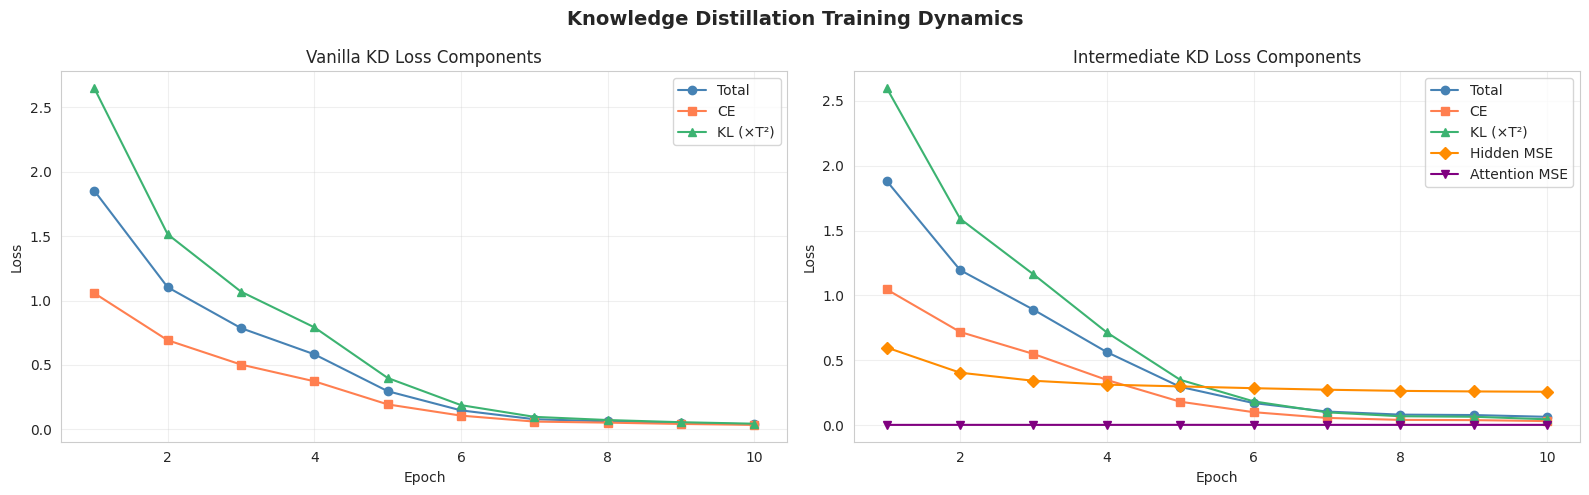

Saved: kd_loss_curves.png


In [41]:
# ── Section 7f: Plot 6 — KD Loss Curves (Side-by-Side) ──────────────────────
# Vanilla KD (left): total, CE, KL loss components.
# Intermediate KD (right): same + hidden state MSE + attention pattern MSE.

import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

LOGS_DIR = Path(PROJECT_PATH) / 'fincompress' / 'logs'
vanilla_log  = pd.read_csv(LOGS_DIR / 'vanilla_kd_training.csv')
intermed_log = pd.read_csv(LOGS_DIR / 'intermediate_kd_training.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(vanilla_log['epoch'], vanilla_log['train_total_loss'], 'o-', color='steelblue',     label='Total')
ax1.plot(vanilla_log['epoch'], vanilla_log['train_ce_loss'],    's-', color='coral',          label='CE')
ax1.plot(vanilla_log['epoch'], vanilla_log['train_kl_loss'],    '^-', color='mediumseagreen', label='KL (×T²)')
ax1.set_title('Vanilla KD Loss Components')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.legend(); ax1.grid(True, alpha=0.3)

intermed_styles = [
    ('train_total_loss',  'o-', 'steelblue',     'Total'),
    ('train_ce_loss',     's-', 'coral',          'CE'),
    ('train_kl_loss',     '^-', 'mediumseagreen', 'KL (×T²)'),
    ('train_hidden_loss', 'D-', 'darkorange',     'Hidden MSE'),
    ('train_attn_loss',   'v-', 'purple',         'Attention MSE'),
]
for col, style, color, label in intermed_styles:
    if col in intermed_log.columns:
        ax2.plot(intermed_log['epoch'], intermed_log[col], style, color=color, label=label)
ax2.set_title('Intermediate KD Loss Components')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend(); ax2.grid(True, alpha=0.3)

fig.suptitle('Knowledge Distillation Training Dynamics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'kd_loss_curves.png', dpi=DPI, bbox_inches='tight')
plt.show()
print("Saved: kd_loss_curves.png")

In [42]:
# ── Section 7g: Plot Summary ──────────────────────────────────────────────────
# Verify all 6 plots were written successfully.

from pathlib import Path
plots = ['pareto_plot.png', 'compression_bar_chart.png', 'latency_distribution.png',
         'f1_degradation_bar.png', 'pruning_curve.png', 'kd_loss_curves.png']

print(f"\n✅ All plots saved to: {PLOTS_DIR}\n")
for p in plots:
    exists = (PLOTS_DIR / p).exists()
    print(f"  {'✓' if exists else '✗'}  {p}")


✅ All plots saved to: /content/drive/MyDrive/fincompress/fincompress/results/plots

  ✓  pareto_plot.png
  ✓  compression_bar_chart.png
  ✓  latency_distribution.png
  ✓  f1_degradation_bar.png
  ✓  pruning_curve.png
  ✓  kd_loss_curves.png


---
## Section 8 — Export Checkpoints

Package all trained checkpoints into a ZIP for download to your local machine. You need them locally to:

- Run the **local CPU benchmark** with accurate hardware timings: `python3 -m fincompress.evaluation.benchmark`
- Launch the **Gradio demo** (side-by-side model comparison): `python3 -m fincompress.demo.app` → http://localhost:7860

The ZIP is saved to your Google Drive root as `fincompress_checkpoints.zip`.

**To download:** open [drive.google.com](https://drive.google.com), right-click `fincompress_checkpoints.zip` → Download.

**To extract locally:** unzip into `FinCompress/fincompress/` — the `checkpoints/` folder should land at `FinCompress/fincompress/checkpoints/`.

In [43]:
# ── Section 8: Export Checkpoints to ZIP ─────────────────────────────────────
# Creates fincompress_checkpoints.zip in your Google Drive root.
# Download it from drive.google.com to use models locally.

import shutil, os

CHECKPOINTS_DIR = os.path.join(PROJECT_PATH, 'fincompress', 'checkpoints')
ZIP_PATH        = '/content/drive/MyDrive/fincompress_checkpoints'

print("Zipping checkpoints (may take a few minutes for large files)...")
shutil.make_archive(ZIP_PATH, 'zip', CHECKPOINTS_DIR)

zip_file = ZIP_PATH + '.zip'
size_mb  = os.path.getsize(zip_file) / 1e6
print(f"\n✅ Archive created: {zip_file}")
print(f"   Size: {size_mb:.1f} MB")
print()
print("Next steps:")
print("  1. Open drive.google.com → find fincompress_checkpoints.zip → Download")
print("  2. Extract to:  ~/Desktop/UMD - MSML/Sem 4/FinCompress/fincompress/")
print("  3. Run locally: python3 -m fincompress.evaluation.benchmark")
print("  4. Run demo:    python3 -m fincompress.demo.app")
print("     Then open:   http://localhost:7860")

Zipping checkpoints (may take a few minutes for large files)...

✅ Archive created: /content/drive/MyDrive/fincompress_checkpoints.zip
   Size: 1443.6 MB

Next steps:
  1. Open drive.google.com → find fincompress_checkpoints.zip → Download
  2. Extract to:  ~/Desktop/UMD - MSML/Sem 4/FinCompress/fincompress/
  3. Run locally: python3 -m fincompress.evaluation.benchmark
  4. Run demo:    python3 -m fincompress.demo.app
     Then open:   http://localhost:7860
